In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import h5py
from cellshapy import Video, VideoCollection
import numpy as np
from IPython.display import HTML

Reading config from /Users/sebastian/Library/Application Support/cellshapy


/Users/sebastian/cellshapy/cellshapy/config/features.py:23: UserWarning: Package pyefd is missing. Some features are not available
/Users/sebastian/cellshapy/cellshapy/config/features.py:23: UserWarning: Package deap is missing. Some features are not available
/Users/sebastian/cellshapy/cellshapy/config/features.py:23: UserWarning: Package mahotas is missing. Some features are not available


In [3]:
CHUNK = 20

In [160]:
file = h5py.File("/Volumes/Data/sebastian/thomas/160506_B03.h5", 'r')
phases = {"1": [83, 304, 421, 503, 509],
"2": [83, 156, 302, 337, 342],
"8": [37, 138, 258, 295, 300],
"9": [37, 146, 265, 307, 311],
 "15": [233, 391, 527, 570, 575],
 "16": [233, 335, 458, 507, 512],
 "22": [56, 154, 274, 308, 313],
 "23": [56, 154, 283, 331, 336],
 "25": [314, 405, 513, 556, 561],
 "31": [74, 191, 333, 389, 394],
 "32": [74, 198, 316, 356, 362],
 "38": [11, 137, 242, 287, 293],
 "39": [11, 131, 268, 301, 305],
 "41": [294, 392, 501, 561, 567],
 "47": [68, 184, 297, 341, 345],
 "48": [68, 195, 299, 347, 351],
 "54": [52, 139, 256, 305, 310],
 "55": [52, 141, 261, 299, 305],
 "61": [111, 252, 377, 424, 429],
 "62": [111, 195, 317, 354, 359],
 "68": [69, 171, 295, 342, 346],
 "69": [69, 172, 289, 330, 334],
 "75": [85, 206, 320, 364, 365],
 "80": [26, 159, 277, 319, 323],
 "81": [26, 157, 276, 338, 342],
 "88": [11, 116, 234, 273, 277],
 "92": [280, 401, 517, 556, 562],
 "93": [280, 399, 522, 556, 562],
 "100": [74, 172, 300, 342, 347],
 "101": [74, 156, 273, 309, 314],
 "107": [13, 280, 401, 440, 446],
 "108": [13, 191, 323, 361, 370]}

In [240]:
#print(f['tracklets']['0']['objects'].keys())
from tqdm import tqdm_notebook as tqdm

idx = 0

vc = VideoCollection()

# iterate over all tracklets
for t in tqdm(file['tracklets'].keys()):
    tracklet = file['tracklets'][t]
    if (len(tracklet['objects']) > CHUNK):
        obj_keys = sorted([int(i) for i in tracklet['objects'].keys()])
        # iterate in reverse in chunks of CHUNK over the track
        start = tracklet['start'][()]
        end = tracklet['end'][()]
        status = tracklet['next_event']['event_id'][()]
        status_id = tracklet['next_event']['name'][()].decode('UTF-8')
        track_id = tracklet['tracklet_id'][()]
        
        # Iterate over all chunks
        for objs in tqdm([obj_keys[::-1][i:i+CHUNK] for i in range(0, len(obj_keys), CHUNK)]):
        # Iterate only over the last chunk
#         for objs in tqdm([obj_keys[::-1][i:i+CHUNK] for i in range(0, CHUNK, CHUNK)]):
            if (len(objs) < CHUNK or status_id != "cell_division"):
                continue
            objs = objs[::-1]
            chunk_min = objs[0]
            chunk_max = objs[-1]
            
            # Get outlines
            outlines = np.array([tracklet['objects'][str(obj)]['outline'][()] for obj in objs])
            
            v = Video.from_contour(contour=outlines, video_index=idx)
            
            [f.updateAnnotation({"frame": f_id}) for f_id, f in zip(objs, v)]
            
            ndist = end - objs[0] if status_id == "cell_division" else -1
            p = phases[str(track_id)] if str(track_id) in phases else []
            
            min_phase = max([pt for pt in p if pt <= chunk_min], default=np.nan)
            max_phase = max([pt for pt in p if pt <= chunk_max], default=np.nan)
            
            for i, frame in enumerate(v):
                f_phase = max([idx for idx, pt in enumerate(p) if pt <= frame.annotations["frame"]], default=np.nan)
                frame.updateAnnotation({'status': status,
                                    'distance': end - (objs[0] + i),
                                    'ndist': ndist,
                                    'id': track_id,
                                    'phases': f_phase})
            v.updateAnnotation({'status': status,
                                'distance': end - objs[0],
                                'ndist': ndist,
                                'id': track_id,
                                'phases': np.mean([f.annotations["phases"] for f in v])})
            if np.isnan(v.annotations["phases"]):
                continue
            vc.videos.append(v)
            idx = idx + 1


In [241]:
print([v.annotations for v in vc[1:10]])
print([v.annotations for v in vc[::-1][1:10]])
print([f.annotations for f in vc[0]])

[{'video': 1, 'status': 1, 'distance': 39, 'ndist': 39, 'id': 1, 'phases': 2.0}, {'video': 2, 'status': 1, 'distance': 59, 'ndist': 59, 'id': 1, 'phases': 2.0}, {'video': 3, 'status': 1, 'distance': 79, 'ndist': 79, 'id': 1, 'phases': 2.0}, {'video': 4, 'status': 1, 'distance': 99, 'ndist': 99, 'id': 1, 'phases': 1.4}, {'video': 5, 'status': 1, 'distance': 119, 'ndist': 119, 'id': 1, 'phases': 1.0}, {'video': 6, 'status': 1, 'distance': 139, 'ndist': 139, 'id': 1, 'phases': 1.0}, {'video': 7, 'status': 1, 'distance': 159, 'ndist': 159, 'id': 1, 'phases': 1.0}, {'video': 8, 'status': 1, 'distance': 179, 'ndist': 179, 'id': 1, 'phases': 1.0}, {'video': 9, 'status': 1, 'distance': 199, 'ndist': 199, 'id': 1, 'phases': 1.0}]
[{'video': 447, 'status': 1, 'distance': 259, 'ndist': 259, 'id': 93, 'phases': 0.0}, {'video': 446, 'status': 1, 'distance': 239, 'ndist': 239, 'id': 93, 'phases': 0.0}, {'video': 445, 'status': 1, 'distance': 219, 'ndist': 219, 'id': 93, 'phases': 0.0}, {'video': 444

In [261]:
print([v.annotations["phases"] for v in vc])

[2.3, 2.0, 2.0, 2.0, 1.4, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.25, 2.0, 1.35, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.0, 0.0, 0.0, 0.0, 2.25, 2.0, 1.05, 1.0, 1.0, 1.0, 1.0, 0.9, 0.0, 0.0, 0.0, 0.0, 2.3, 2.0, 1.25, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.45, 2.0, 1.35, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.25, 2.0, 1.4, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.25, 2.0, 1.7, 1.0, 1.0, 1.0, 1.0, 1.0, 0.85, 0.0, 0.0, 0.0, 0.0, 2.25, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.0, 0.0, 2.25, 1.95, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.0, 0.0, 0.0, 0.0, 2.25, 2.0, 1.65, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.1, 0.0, 0.0, 0.0, 0.0, 2.25, 2.0, 1.4, 1.0, 1.0, 1.0, 1.0, 0.8, 0.0, 0.0, 0.0, 0.0, 2.25, 2.0, 2.0, 1.05, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.15, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3, 2.0, 1.3, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3, 2

In [243]:
vc.get_annotations_videos()["phases"]

0      2.30
1      2.00
2      2.00
3      2.00
4      1.40
5      1.00
6      1.00
7      1.00
8      1.00
9      1.00
10     0.25
11     0.00
12     0.00
13     0.00
14     0.00
15     0.00
16     0.00
17     0.00
18     0.00
19     0.00
20     0.00
21     2.25
22     2.00
23     1.35
24     1.00
25     1.00
26     1.00
27     1.00
28     1.00
29     0.75
       ... 
419    0.00
420    0.00
421    2.30
422    2.00
423    1.25
424    1.00
425    1.00
426    1.00
427    1.00
428    1.00
429    0.05
430    0.00
431    0.00
432    0.00
433    0.00
434    0.00
435    2.30
436    2.00
437    1.00
438    1.00
439    1.00
440    1.00
441    1.00
442    1.00
443    0.15
444    0.00
445    0.00
446    0.00
447    0.00
448    0.00
Name: phases, Length: 449, dtype: float64

In [244]:
for v in vc:
    if np.isnan(v.annotations['phases']):
        v.updateAnnotation({"phases": -1})
    for f in v:
        if np.isnan(f.annotations['phases']):
            f.updateAnnotation({"phases": -1})

Iteration 2, error: 0.000022, time: 13.43 sec
8980 contours aligned in 21.40 sec


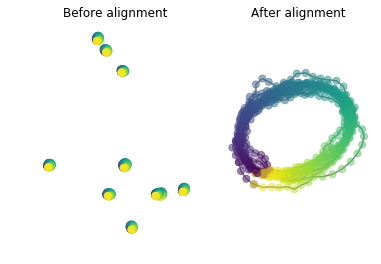

In [245]:
_ = vc.align_contours()

In [246]:
vc.embed_morphs(format='stxy', method='parafac', n_components=2)

`parafac` embedding for `stxy` done (0.19 s).


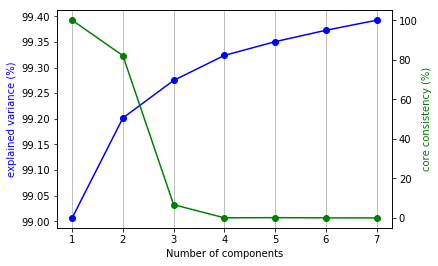

(              core consistency  explained variance
 n_components                                      
 1                   100.000000           99.006607
 2                    82.082036           99.201564
 3                     6.685859           99.274825
 4                     0.021297           99.323575
 5                     0.109148           99.350371
 6                    -0.003779           99.372595
 7                    -0.026047           99.392195,
 <Figure size 432x288 with 2 Axes>)

In [247]:
vc.parafac_diagnostics(format='stxy', max_components=8)

In [255]:
vc.embed_morphs(format='stxy', method='parafac', n_components=2)

`parafac` embedding for `stxy` done (0.19 s).


num_frames = 20


/Users/sebastian/cellshapy/cellshapy/plotting/morphspace.py:369: UserWarning: Projecting from 2 components to 2D using pca.


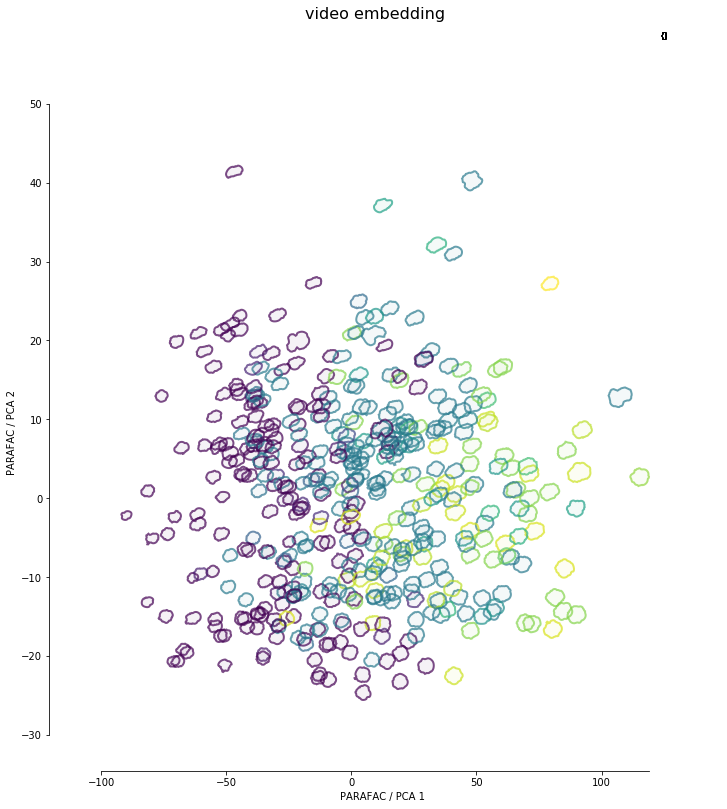

In [256]:
anim = vc.morph_space(format='stxy', method='parafac', colorcode='phases', animate=True, alpha_face=0.05, projection='pca', duration=2.0)

In [257]:
HTML(anim.to_html5_video())

factor.shape = (506, 2)
factor.shape = (20, 2)
factor.shape = (98, 2)
(100, 2)
reconstruct_tensor reconstruction.shape:  (100, 20, 98)
format =  stxy
(100, 20, 49, 2)
num_frames = 20


/Users/sebastian/cellshapy/cellshapy/plotting/morphspace.py:353: UserWarning: Using only components [1, 2]
/Users/sebastian/cellshapy/cellshapy/plotting/morphspace.py:369: UserWarning: Projecting from 2 components to 2D using pca.


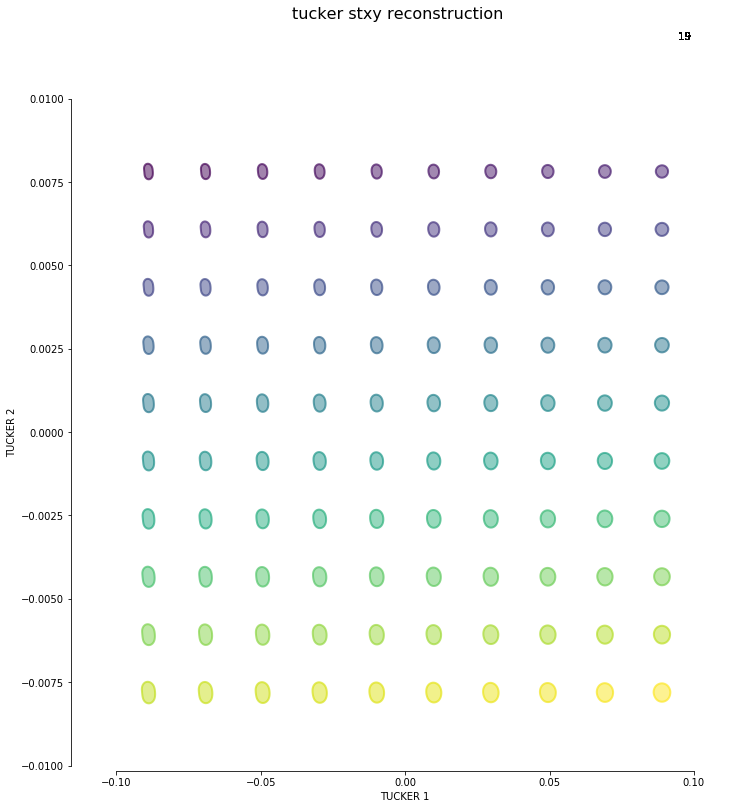

In [238]:
HTML(vc.morph_space_reconstruction('stxy', 'tucker', 10).to_html5_video())

In [259]:
vc.embed_shapes('contours', 'pca')

`pca` embedding for `contours` done (0.13 s).


/Users/sebastian/cellshapy/cellshapy/plotting/shapespace.py:51: UserWarning: No need to perform pca projection. Data already 2D.


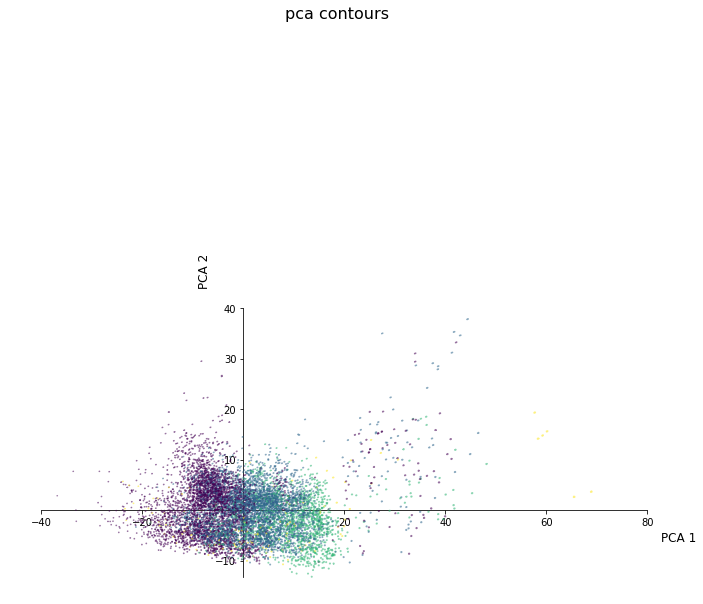

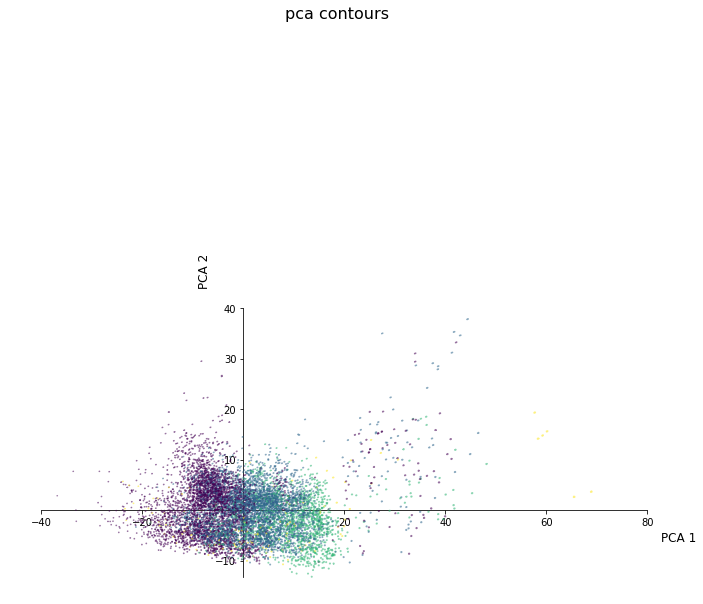

In [260]:
vc.shape_space('contours', 'pca', colorcode='phases')

In [29]:
f['objects']['frames']['0']['slices']['0']['channels']['0']['objects']['1']['outline'][()]

array([[ 0, 60],
       [ 0, 81],
       [ 2, 81],
       [ 3, 82],
       [ 7, 82],
       [ 8, 81],
       [11, 81],
       [11, 80],
       [12, 79],
       [12, 68],
       [ 9, 65],
       [ 8, 65],
       [ 6, 63],
       [ 6, 62],
       [ 5, 61],
       [ 4, 61],
       [ 3, 60]], dtype=uint32)